In [56]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


D:\Programs\anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## О чем данные: расчетное потребление энергии в мегаваттах (МВт) каждый час. Данные подготовленны Duquesne Light Holdings, Inc. Энергия измерялась в Пенсильвании

Сделаем ресемпл данных, чтобы лучше видеть, как обучается модель.

In [57]:
db = 'DUQ_hourly.csv'
data = pd.read_csv(db)
data["Datetime"] = pd.to_datetime(data["Datetime"])
data

,Datetime,DUQ_MW
0,2005-12-31 01:00:00,1458.0
1,2005-12-31 02:00:00,1377.0
2,2005-12-31 03:00:00,1351.0
3,2005-12-31 04:00:00,1336.0
4,2005-12-31 05:00:00,1356.0
...,...,...
119063,2018-01-01 20:00:00,1962.0
119064,2018-01-01 21:00:00,1940.0
119065,2018-01-01 22:00:00,1891.0
119066,2018-01-01 23:00:00,1820.0


In [58]:
data['date_minus_time'] = data["Datetime"].apply( lambda data : 
datetime.datetime(year=data.year, month=data.month, day=data.day))
data.set_index(data["date_minus_time"],inplace=True)
data

,Datetime,DUQ_MW,date_minus_time
date_minus_time,,,
2005-12-31,2005-12-31 01:00:00,1458.0,2005-12-31
2005-12-31,2005-12-31 02:00:00,1377.0,2005-12-31
2005-12-31,2005-12-31 03:00:00,1351.0,2005-12-31
2005-12-31,2005-12-31 04:00:00,1336.0,2005-12-31
2005-12-31,2005-12-31 05:00:00,1356.0,2005-12-31
...,...,...,...
2018-01-01,2018-01-01 20:00:00,1962.0,2018-01-01
2018-01-01,2018-01-01 21:00:00,1940.0,2018-01-01
2018-01-01,2018-01-01 22:00:00,1891.0,2018-01-01


In [59]:
data = data.resample('W', on = 'date_minus_time').sum()
data

,DUQ_MW
date_minus_time,
2005-01-02,64069.0
2005-01-09,273052.0
2005-01-16,274529.0
2005-01-23,301980.0
2005-01-30,297042.0
...,...
2018-07-08,323737.0
2018-07-15,322957.0
2018-07-22,307617.0


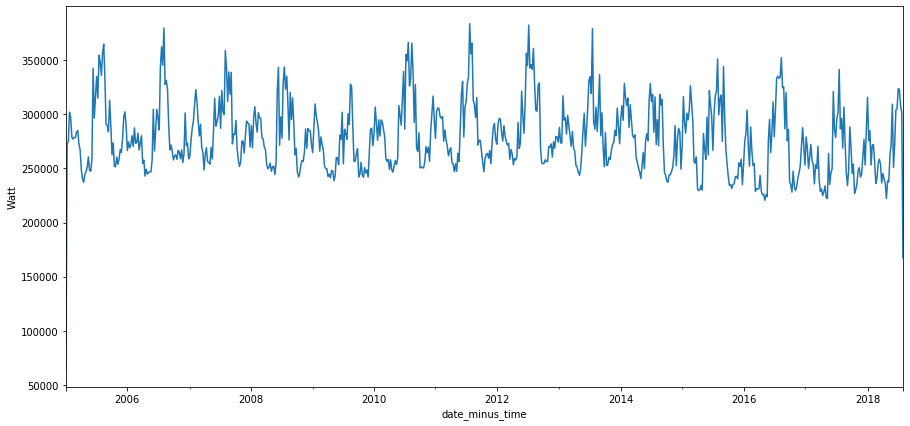

In [60]:
plt.figure(figsize(15,7))
data['DUQ_MW'].plot()
plt.ylabel('Watt')
pylab.show()

    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature

In [61]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [62]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,DUQ_MW,weekday,is_weekend
date_minus_time,,,
2005-01-02,64069.0,6,1
2005-01-09,273052.0,6,1
2005-01-16,274529.0,6,1
2005-01-23,301980.0,6,1
2005-01-30,297042.0,6,1


### Разбиваем данные для обучения модели

In [63]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

#     data.index = data.index.to_datetime()
#     data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
#     data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
#     data.drop(["hour", "weekday"], axis=1, inplace=True)
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

### Linear regression

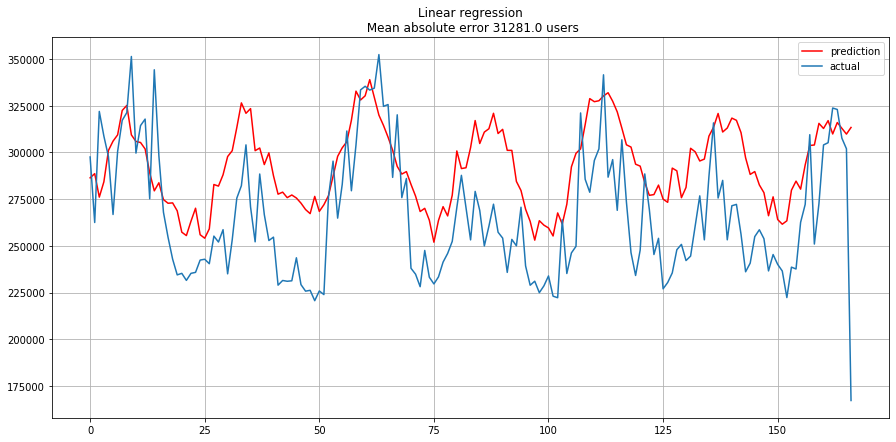

In [64]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(data['DUQ_MW'], test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

## Попробуем xgboost

In [65]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.3, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data['DUQ_MW'], lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1500

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train, label='prediction')
    plt.plot(y_train, label='y_train')
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {}".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend

[11:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:16

D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


[11:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


D:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


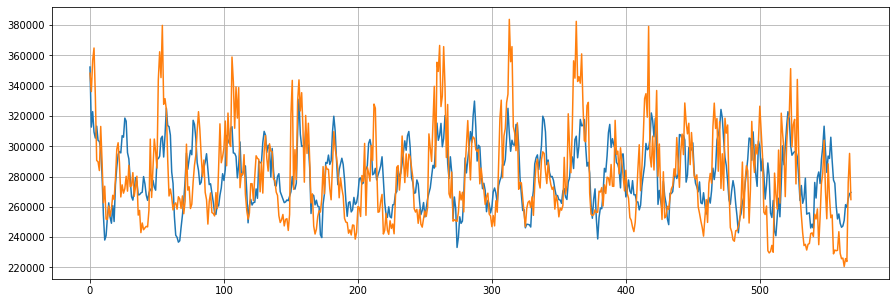

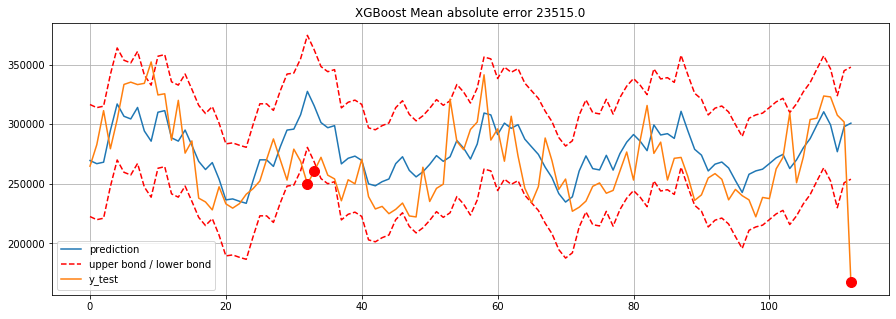

In [66]:
XGB_forecast(data, test_size=0.2, lag_start=5, lag_end=30)

### Вывод: xgboost > linear reg, т.к. средне-квадратичная ошибка у него меньше